In [1]:
## tensorflow-gpu==2.3.0 bug to load_weight after call inference
!pip install tensorflow-gpu==2.2.0

  Using cached tensorflow_gpu-2.2.0-cp37-cp37m-manylinux2010_x86_64.whl (516.2 MB)
  Using cached tensorflow_estimator-2.2.0-py2.py3-none-any.whl (454 kB)
  Using cached tensorboard-2.2.2-py3-none-any.whl (3.0 MB)
ERROR: tensorflowtts 0.0 has requirement tensorflow-gpu==2.3.0, but you'll have tensorflow-gpu 2.2.0 which is incompatible.
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Attempting uninstall: tensorflow-gpu
    Found existing installation: tensorflow-gpu 2.3.0
    Uninstalling tensorflow-gpu-2.3.0:
      Successfully uninstalled tensorflow-gpu-2.3.0


In [2]:
import yaml
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow_tts.inference import AutoConfig
from tensorflow_tts.inference import TFAutoModel
from tensorflow_tts.inference import AutoProcessor

In [3]:
processor = AutoProcessor.from_pretrained(
    pretrained_path="../tensorflow_tts/processor/pretrained/ljspeech_mapper.json"
)

In [4]:
input_text = "i love you so much."
input_ids = processor.text_to_sequence(input_text)

In [5]:
config = AutoConfig.from_pretrained("../examples/fastspeech2/conf/fastspeech2.v1.yaml")
fastspeech2 = TFAutoModel.from_pretrained(
    config=config, 
    pretrained_path=None, # "../examples/fastspeech2/checkpoints/model-150000.h5",
    is_build=False, # don't build model if you want to save it to pb. (TF related bug)
    name="fastspeech2"
)

# Save to Pb

In [6]:
mel_before, mel_after, duration_outputs, _, _ = fastspeech2.inference(
    input_ids=tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0),
    speaker_ids=tf.convert_to_tensor([0], dtype=tf.int32),
    speed_ratios=tf.convert_to_tensor([1.0], dtype=tf.float32),
    f0_ratios =tf.convert_to_tensor([1.0], dtype=tf.float32),
    energy_ratios =tf.convert_to_tensor([1.0], dtype=tf.float32),
)

In [7]:
fastspeech2.load_weights("../examples/fastspeech2/checkpoints/fastspeech2.v1-150K.h5")

In [8]:
# save model into pb and do inference. Note that signatures should be a tf.function with input_signatures.
tf.saved_model.save(fastspeech2, "./test_saved", signatures=fastspeech2.inference)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./test_saved/assets


# Load and Inference

In [9]:
fastspeech2 = tf.saved_model.load("./test_saved")

In [10]:
input_text = "There’s a way to measure the acute emotional intelligence that has never gone out of style."
input_ids = processor.text_to_sequence(input_text)

In [11]:
mel_before, mel_after, duration_outputs, _, _ = fastspeech2.inference(
    input_ids=tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0),
    speaker_ids=tf.convert_to_tensor([0], dtype=tf.int32),
    speed_ratios=tf.convert_to_tensor([1.0], dtype=tf.float32),
    f0_ratios =tf.convert_to_tensor([1.0], dtype=tf.float32),
    energy_ratios =tf.convert_to_tensor([1.0], dtype=tf.float32)
)

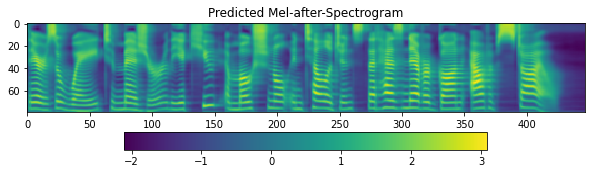

In [12]:
mel_after = tf.reshape(mel_after, [-1, 80]).numpy()
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-after-Spectrogram')
im = ax1.imshow(np.rot90(mel_after), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()
plt.close()

# Let inference other input to check dynamic shape

In [13]:
input_text = "The Commission further recommends that the Secret Service coordinate its planning as closely as possible with all of the Federal agencies from which it receives information."
input_ids = processor.text_to_sequence(input_text)

In [14]:
mel_before, mel_after, duration_outputs, _, _ = fastspeech2.inference(
    input_ids=tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0),
    speaker_ids=tf.convert_to_tensor([0], dtype=tf.int32),
    speed_ratios=tf.convert_to_tensor([1.0], dtype=tf.float32),
    f0_ratios =tf.convert_to_tensor([1.0], dtype=tf.float32),
    energy_ratios =tf.convert_to_tensor([1.0], dtype=tf.float32)
)

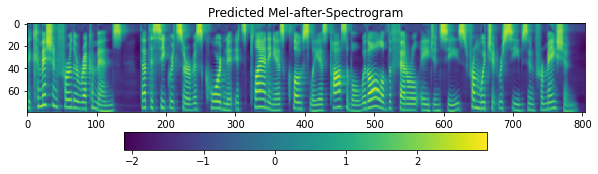

In [15]:
mel_after = tf.reshape(mel_after, [-1, 80]).numpy()
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-after-Spectrogram')
im = ax1.imshow(np.rot90(mel_after), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()
plt.close()